# Description of the problem and dataset

Customer churn (or customer attrition) is a tendency of customers to abandon a brand/bank. The percentage of customers that discontinue using a company’s products or services during a particular time period is called a customer churn (attrition) rate.

The original dataset, also known as **Credit Card Customer** dataset and can be found on Kaggle https://www.kaggle.com/datasets/anwarsan/credit-card-bank-churn, contains informations about 10,000 customers mentioning their age, income, marital status, credit card limit, credit card category, etc. There is about 16.07% of customers who have churned and nearly 18 features : 

- *Clientium* : Unique identifier for the customer holding the account
- *Attrition*: Internal event (customer activity) variable - this is our target
- *Age*: Customer's Age in Years.
- *Gender*: M=Male, F=Female.
- *Dependent_count*: Number of dependents.
- *Education*: Educational Qualification of the account holder. 
- *Marital_Status*: Married, Single, Divorced, Unknown.
- *Income*: Annual Income Category of the account holder. 
- *Card_Category*: Type of Card (Blue, Silver, Gold, Platinum). 
- *Months_on_book*: Period of relationship with bank.
- *Total_Relationship_Count*: Total no. of products held by the customer.
- *Months_Inactive*: No. of Months in the last 12 months.
- *Contacts_Count*: No. of Contacts in the last 12 months.
- *Credit_Limit*': Credit Limit on the Credit Card.
- *Total_Revolving_Bal*: Total Revolving Balance on the Credit Card.
- *Avg_Open_To_Buy*: Open to Buy Credit Line (Average of last 12 months
- *Total_Amt_Chng_Q4_Q1*: Change in Transaction Amount (Q4 over Q1).
- *Total_Trans_Amt*: Total Transaction Amount (Last 12 months).
- *Total_Trans_Ct*: Total Transaction Count (Last 12 months).
- *Total_Ct_Chng_Q4_Q1*: Change in Transaction Count (Q4 over Q1).
- *Avg_Utilization_Ratio*: Average Card Utilization Ratio.

A manager at the bank is disturbed with more and more customers leaving their credit card services. They're not interested only on predicting customers *willing* churn (and thus provide them proactively better services and turn customers' decisions in the opposite direction) but also if there's a specific reason making them a churning constumer. The manager thinks that the traditional approach of choosing a credit card for a customer needs to change and may be one of the reasons that leads customers are canceling their accounts.

Based on Propensity Score Matching, the goal of this project is to provide a causal analysis to show if the credit card category (standard or VIP) has an real/significant effect on customer's churning.

# Import all required packages and librairies

In [32]:
import pandas as pd
import numpy as np

from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.formula.api as smf


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from tableone import TableOne

# Import the original Kaggle dataset

In [2]:
original_df = pd.read_csv("C:/Users/nacha/OneDrive/Documents/VersusMind/BankChurners.csv")

Let us take a first look on the dataset:

In [3]:
original_df.sample(5, random_state=5)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
1646,716870583,Existing Customer,36,F,3,Unknown,Married,Less than $40K,Blue,36,...,2786.0,1628,1158.0,1.314,2853,55,0.667,0.584,0.000385,0.999610
7880,708307533,Existing Customer,42,M,2,Uneducated,Married,$60K - $80K,Blue,30,...,3086.0,0,3086.0,0.808,4129,81,0.884,0.000,0.000197,0.999800
7586,713381433,Attrited Customer,38,F,1,High School,Married,Less than $40K,Blue,28,...,4196.0,731,3465.0,0.485,1868,30,0.200,0.174,0.996390,0.003609
9646,710667708,Existing Customer,47,M,2,Uneducated,Single,$60K - $80K,Blue,36,...,12510.0,1871,10639.0,0.748,14018,128,0.778,0.150,0.000185,0.999820
7165,708108333,Attrited Customer,47,F,3,Graduate,Married,Unknown,Blue,36,...,5590.0,0,5590.0,0.010,1507,32,0.000,0.000,0.991200,0.008800


We shall proceed now on the data preprocessing phase

# Data Preprocessing

*Step 1 - Remove unnecessary/dummy columns :* CLIENTNUM, Gender, Marital_Status and the last two variables

In [4]:
to_remove_colnames = ["CLIENTNUM", "Gender", "Marital_Status"] +  list(original_df.columns[-2:])
useful_df = original_df.drop(to_remove_colnames, axis = 1)

*Step 2 - Convert categorical inputs to numerical inputs* : Instead of applying One-Hot-Encoding, I proceed manually in converting these columns by attributing numerical scores to each class.

*Attrition_Flag*: If the account is closed then 1 else 0.

In [5]:
useful_df['Attrition_Flag'] = useful_df['Attrition_Flag'].replace(['Existing Customer', 'Attrited Customer'], [0, 1])

*Card_Category*: This column is transformed into binary column, 0 if the credit_card is "Blue" and 1 otherwise.

In [6]:
Card_values = useful_df['Card_Category'].unique().tolist()
Card_values

['Blue', 'Gold', 'Silver', 'Platinum']

In [7]:
Card_correspond_list = [0, 1, 1, 1]
useful_df['Card_Category'] = useful_df['Card_Category'].replace(Card_values, Card_correspond_list)

*Education_Level*: This column is transformed into numerical column with coefficients to each educational level describing the hardness of the qualification (from 0 for uneducated to 10 for Doctorate, NA for unkown).

In [8]:
Education_values = useful_df['Education_Level'].unique().tolist()
Education_values

['High School',
 'Graduate',
 'Uneducated',
 'Unknown',
 'College',
 'Post-Graduate',
 'Doctorate']

In [9]:
Education_correspond_list = [4, 6, 0,  np.nan, 2, 8, 10]
useful_df['Education_Level'] = useful_df['Education_Level'].replace(Education_values, Education_correspond_list)

*Income_Category*: This column is also transformed into numerical column by taking the average of each income interval and the unkown income are marked as NA.

In [10]:
Income_values = useful_df['Income_Category'].unique().tolist()
Income_values

['$60K - $80K',
 'Less than $40K',
 '$80K - $120K',
 '$40K - $60K',
 '$120K +',
 'Unknown']

In [11]:
Income_correspond_list = [70000, 30000, 100000, 50000, 140000,  np.nan]
useful_df['Income_Category'] = useful_df['Income_Category'].replace(Income_values, Income_correspond_list)

*Step 3: Check and remove for null values* : drop all missing values in the Income and Education variables.

In [12]:
clean_df = useful_df.dropna()

In [13]:
print("There are " + str(clean_df.shape[0]) + " rows and " + str(clean_df.shape[1]) + " features in the cleaned data.")

There are 7641 rows and 18 features in the cleaned data.


In [21]:
churned_customers_perc = 100*clean_df['Attrition_Flag'].value_counts()[1]/clean_df.shape[0]
print("There is about " + str(round(churned_customers_perc,2)) + "% of customers who have churned in the cleaned dataset")

There is about 15.85% of customers who have churned in the cleaned dataset


Export the cleaned dataset for further use.

In [22]:
clean_df.to_csv('BankChurners_cleaned.csv', index=False, header=True)

# Estimating the effect of having a VIP or standard credit card

**Define the treatment W, the outcome Y and the covariates X**

In [23]:
Treatment_W = 'Card_Category'
outcome_Y = 'Attrition_Flag'
Covariates_X = clean_df.columns.drop([Treatment_W, outcome_Y])

**Compute the apparent effect of having a VIP or standard credit card** 

In [24]:
treated_units = clean_df[clean_df[Treatment_W]== 1]
Avg_treated = 100*treated_units[outcome_Y].mean()

ctrl_units = clean_df[clean_df[Treatment_W] == 0]
Avg_ctrl = 100*ctrl_units[outcome_Y].mean()

In [25]:
Observed_ATE = Avg_treated - Avg_ctrl
print("The percentage of customers who have churned with a VIP Credit Card : " + str("{:.2f}".format(float(Avg_treated))) + ' %')
print("The percentage of customers who have churned with a standard Credit Card :  " + str("{:.2f}".format(float(Avg_ctrl))) + ' %')
print("The Observed treatment effect of having a VIP Credit Card : " + str("{:.2f}".format(float(Observed_ATE))) + ' %')

The percentage of customers who have churned with a VIP Credit Card : 16.26 %
The percentage of customers who have churned with a standard Credit Card :  15.82 %
The Observed treatment effect of having a VIP Credit Card : 0.44 %


Basically, having a VIP Credit Card does not contribute to the churning of clients.

**Plot a barplot figure showing the percentage of churned customers**

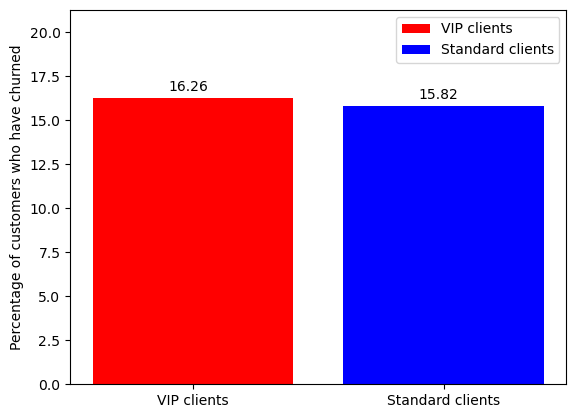

In [29]:
# Add a barplot
labels = ('VIP clients', 'Standard clients') 
height = [Avg_treated, Avg_ctrl]
y_pos = np.arange(len(labels))

plt.bar(y_pos[0], height[0], color = 'red', label = labels[0])
plt.bar(y_pos[1], height[1], color = 'blue', label = labels[1])
plt.xticks(y_pos, labels)
plt.ylabel("Percentage of customers who have churned")
plt.ylim(0, max(Avg_treated, Avg_ctrl)+5) 
ticketslabel = [Avg_treated, Avg_ctrl]
 
# Text on the top of each barplot
for i in range(2):
    plt.text(x = i-0.1 , y = height[i] + 0.4, s = "{:.2f}".format(float(ticketslabel[i])), size = 10)

# Adjust the margins
plt.subplots_adjust(bottom = 0.2, top = 0.98)
plt.legend()
plt.show()

**Show the summary statistics table on both treated and control units**

In [41]:
table_data = clean_df
columns = Covariates_X.tolist()
table_data.reset_index(drop = True, inplace = True)
mytable = TableOne(table_data, columns = columns, groupby = "Card_Category", pval = True) 

In [42]:
print(mytable.tabulate(tablefmt="github"))

|                                  |          | Missing   | Overall         | 0               | 1                | P-Value   |
|----------------------------------|----------|-----------|-----------------|-----------------|------------------|-----------|
| n                                |          |           | 7641            | 7106            | 535              |           |
| Customer_Age, mean (SD)          |          | 0         | 46.3 (8.0)      | 46.3 (8.0)      | 46.0 (7.0)       | 0.321     |
| Dependent_count, n (%)           | 0        | 0         | 666 (8.7)       | 620 (8.7)       | 46 (8.6)         | 0.035     |
|                                  | 1        |           | 1378 (18.0)     | 1300 (18.3)     | 78 (14.6)        |           |
|                                  | 2        |           | 2003 (26.2)     | 1867 (26.3)     | 136 (25.4)       |           |
|                                  | 3        |           | 2104 (27.5)     | 1961 (27.6)     | 143 (26.7)     

Features that differ significantly between treated and control units are the ones whose p-value is below 0.05. In particular, one can read in this table that users with a VIP card tend to have less Dependent_count, more Income_Category, more Credit_Limit, more Transactions on their bank account and more average utilization ratio.

# Causal Inference with Propensity score Matching

**Estimating Propensity score by a logstic regression** 

In this step, we build a statistical model to estimate the propensity score $e(x)= \mathbb{P}(T=1 | X=x)$, the most common and famous model to do so is the logistic regression.

In [33]:
ps_logit_reg = LogisticRegression().fit(clean_df[Covariates_X], clean_df[Treatment_W])
data_ps = clean_df.assign(propensity_score = ps_logit_reg.predict_proba(clean_df[Covariates_X])[:, 1])

Note that other Machine Learning algorithms can be applied such as Random Forest or Gradient Boosting.

In [35]:
ps_RandomForest = RandomForestClassifier().fit(clean_df[Covariates_X], clean_df[Treatment_W])
ps_GradientBoost = GradientBoostingClassifier().fit(clean_df[Covariates_X], clean_df[Treatment_W])

**Propensity Score Matching: match treated and control units w.r.t to the estimated Propensity Score**. 

Once the propensity score $e$ is estimated, we need to match treated and control units based on their propensity score estimation$. We will use the following matching algorithm that considers methods :
- "Min" method : Pick the closest pair of an untreated unit (standard customer) to a treated unit (VIP customer) given the threshold. the matching is done without any guaranties of its goodness. 
- "Random" method : Fix a threshold and a number of matched unit (nmatches = 1 as default value). Select all untreated units such that the distance of Propensity score is smaller than the threshold and finally pick a random unit. The matching may not be achieved all time but the goodness of matching is satisfied and guaranteed by the threshold parameter.

In [37]:
# Define the propensity score for each treated and control units
treat_scores = data_ps[data_ps[Treatment_W]==1][['propensity_score']]
n_treated = len(treat_scores)
ctrl_scores = data_ps[data_ps[Treatment_W]==0][['propensity_score']]

# Choose the parameters of matching algorithm
threshold = 10e-3 # The threshold below which we look for the possibly matched units in control units
nmatches = 1 # The number of control units to match with from a given treated unit
max_rand = 10 # The maximum of allowed matched units when applying "Random" method
method = 'min'

# Run the matching algorithm
result, match_ids = [], []
for i in range(len(treat_scores)):
    score = treat_scores.iloc[i]
    if method == 'random':
        # Select randomly nmatch units such that the propensity score is below threshold
        bool_match = abs(ctrl_scores - score) <= threshold
        matches = ctrl_scores.loc[bool_match[bool_match.propensity_score].index]
    elif method == 'min':
        # Select the most closets nmatch units such that the propensity score is below threshold
        matches = abs(ctrl_scores - score).sort_values('propensity_score').head(nmatches)
    if len(matches) == 0:
        continue
    # randomly choose nmatches indices, if len(matches) > nmatches
    select = nmatches if method != 'random' else np.random.choice(range(1, max_rand+1), 1)
    chosen = np.random.choice(matches.index, min(select, nmatches), replace = False)
    # Append the index of each unit and the corresponding matched treated units
    match_ids.extend([i] * (len(chosen)+1))
    result.extend([treat_scores.index[i]] + list(chosen))
    
# Create a dataframe with the id of each treated unit and the matched control units
matched_data = data_ps.loc[result]
matched_data['match_id'] = match_ids # the id of matched unit for control units 
matched_data['record_id'] = matched_data.index # the id of each unit of treated units

In [38]:
matched_data

,Attrition_Flag,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,...,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,propensity_score,match_id,record_id
6,0,32,0,4.0,70000.0,1,27,2,2,2,...,1396,27685.0,2.204,1538,36,0.714,0.048,0.942201,0,6
7191,0,38,2,4.0,100000.0,0,31,1,3,2,...,0,34516.0,0.768,14036,99,0.768,0.000,0.916996,0,7191
27,0,42,4,4.0,30000.0,1,36,2,3,3,...,0,15433.0,0.865,966,22,1.200,0.000,0.753863,1,27
3500,0,46,5,0.0,100000.0,0,28,6,1,1,...,1259,33257.0,0.671,4300,94,0.741,0.036,0.754960,1,3500
30,0,50,1,2.0,50000.0,1,43,3,2,3,...,2517,14787.0,1.449,1756,33,1.200,0.145,0.288497,2,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3359,1,43,2,6.0,100000.0,0,30,3,3,3,...,0,34516.0,0.688,2427,51,0.645,0.000,0.810057,532,3359
7629,1,33,2,2.0,140000.0,1,20,2,1,4,...,0,34516.0,1.004,9338,73,0.622,0.000,0.125841,533,7629
6554,0,53,2,4.0,30000.0,0,49,1,2,3,...,1710,7968.0,0.745,7682,90,0.579,0.177,0.126309,533,6554
7640,1,43,2,6.0,30000.0,1,25,6,2,4,...,1961,8427.0,0.703,10294,61,0.649,0.189,0.412528,534,7640


**Compute the causal treatment effect of having a VIP or standard credit card on churning customers :**

In [39]:
matched_Avg_treated = 100*matched_data[outcome_Y][matched_data[Treatment_W]==1].mean()
matched_Avg_ctrl = 100*matched_data[outcome_Y][matched_data[Treatment_W]==0].mean()

In [79]:
Causal_ATE = matched_Avg_treated - matched_Avg_ctrl
print("The percentage of customers who have churned with a VIP Credit Card : " + str("{:.2f}".format(float(matched_Avg_treated))) + ' %')
print("The percentage of customers who have churned with a standard Credit Card :  " + str("{:.2f}".format(float(matched_Avg_ctrl))) + ' %')
print("The causal treatment effect of having a VIP Credit Card : " + str("{:.2f}".format(float(Causal_ATE))) + ' %')

The percentage of customers who have churned with a VIP Credit Card : 16.26 %
The percentage of customers who have churned with a standard Credit Card :  9.91 %
The causal treatment effect of having a VIP Credit Card : 6.36 %


**Plot a barplot figure showing the percentage of churned customers**

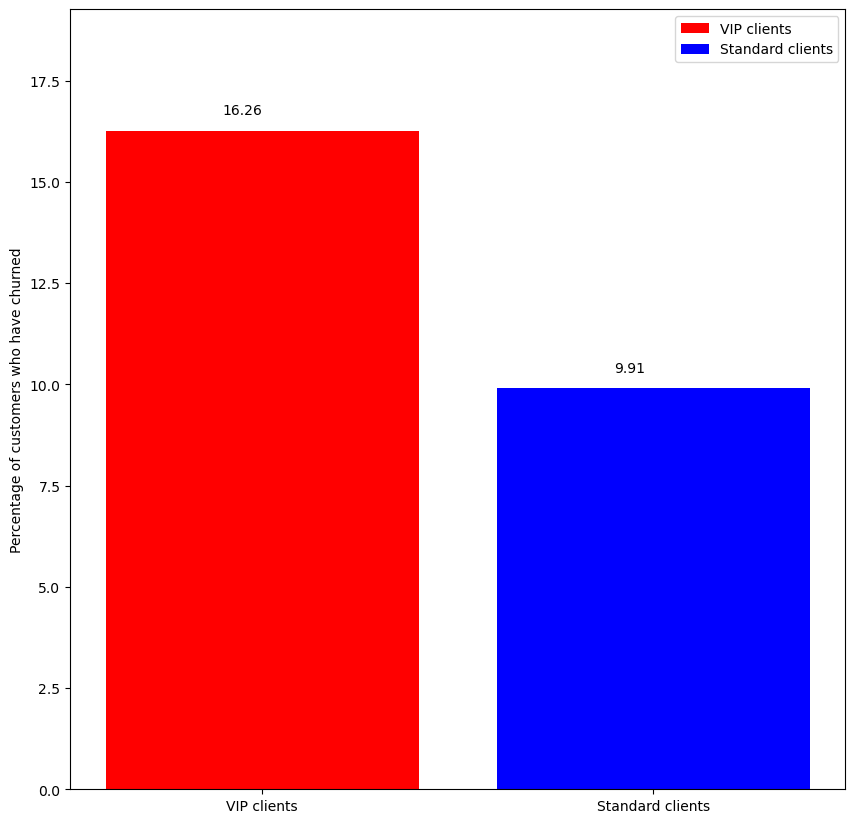

In [51]:
# Add a barplot
labels = ('VIP clients', 'Standard clients') 
height = [matched_Avg_treated, matched_Avg_ctrl]
y_pos = np.arange(len(labels))

plt.bar(y_pos[0], height[0], color = 'red', label = labels[0])
plt.bar(y_pos[1], height[1], color = 'blue', label = labels[1])
plt.xticks(y_pos, labels)
plt.ylabel("Percentage of customers who have churned")
plt.ylim(0, max(matched_Avg_treated, matched_Avg_ctrl)+3) 
ticketslabel = [matched_Avg_treated, matched_Avg_ctrl]
 
# Text on the top of each barplot
for i in range(2):
    plt.text(x = i-0.1 , y = height[i] + 0.4, s = "{:.2f}".format(float(ticketslabel[i])), size = 10)

# Adjust the margins
plt.subplots_adjust(bottom = 0.2, top = 0.98)
plt.legend()
plt.show()

**Conclusion** : The credit card category has a significant impact and may be a reason of customer's churn.  

**Recommandation** : The bank manager should understand why VIP clients are more likely to churn than standards client.
Maybe the price of VIP cards are not attractive? maybe they are not satisfied from the services? etc.

**Show the summary statistics table on both treated and control units**

In [52]:
matched_table_data = matched_data.drop(['match_id', 'propensity_score', 'record_id'], axis = 1)
matched_table_data.reset_index(drop=True, inplace=True)
matched_table_data.index = range(1,matched_table_data.shape[0]+1)
mytable = TableOne(matched_table_data, columns = columns, groupby = "Card_Category", pval = True) 

In [53]:
print(mytable.tabulate(tablefmt="github"))

|                                     |          | Missing   | Overall          | 0                | 1                | P-Value   |
|-------------------------------------|----------|-----------|------------------|------------------|------------------|-----------|
| n                                   |          |           | 1070             | 535              | 535              |           |
| Customer_Age, mean (SD)             |          | 0         | 44.6 (7.0)       | 43.3 (6.8)       | 46.0 (7.0)       | <0.001    |
| Dependent_count, mean (SD)          |          | 0         | 2.4 (1.3)        | 2.3 (1.2)        | 2.5 (1.3)        | 0.019     |
| Education_Level, mean (SD)          |          | 0         | 4.3 (2.6)        | 4.1 (2.5)        | 4.4 (2.7)        | 0.062     |
| Income_Category, n (%)              | 100000.0 | 0         | 477 (44.6)       | 350 (65.4)       | 127 (23.7)       | <0.001    |
|                                     | 140000.0 |           | 78 (7.3)     

**Check covariates balancing with densities and histograms :**  
Additional work may be needed to check covariates balancing for each type of columns (categorial, binary, discret and continunous)

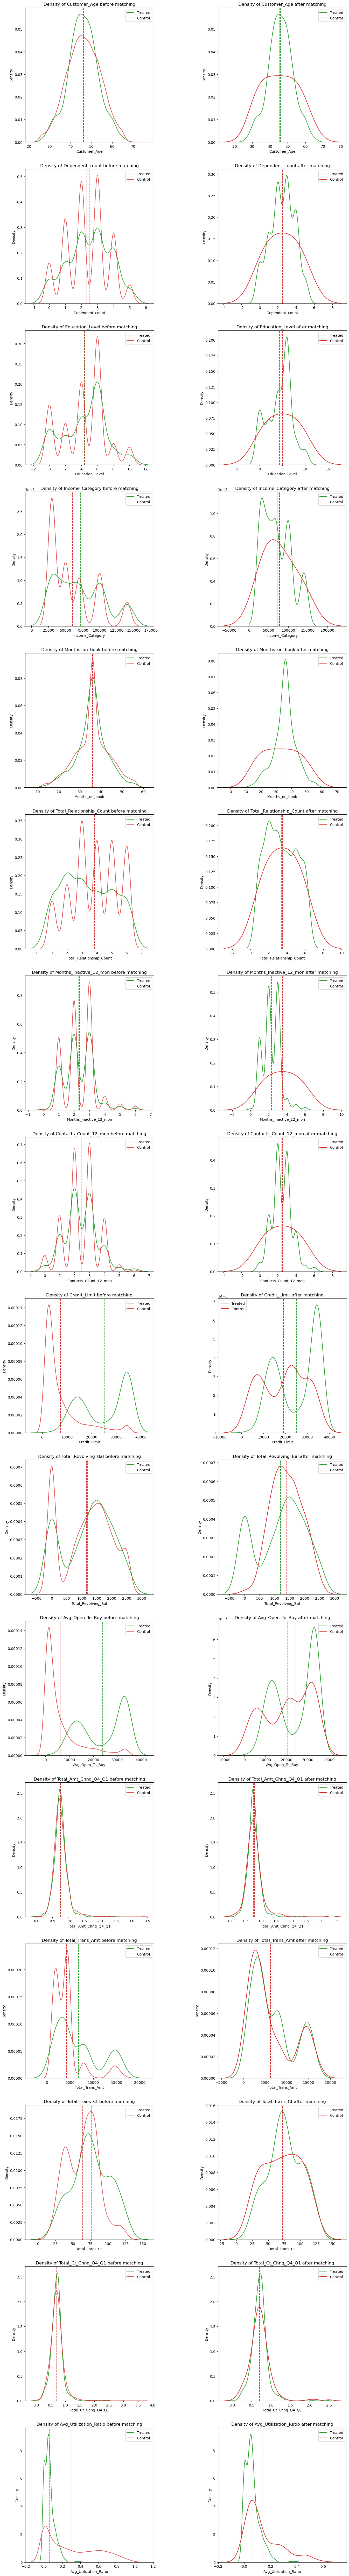

In [80]:
fig, axs = plt.subplots(Covariates_X.shape[0], 2, figsize=(Covariates_X.shape[0]*1, Covariates_X.shape[0]*8))

for j in range(Covariates_X.shape[0]):
    Xj = Covariates_X[j] 
    
    # Plot the density of two population before matching
    sns.kdeplot(clean_df[clean_df[Treatment_W] == 1][Xj], color="C2", label="Treated", ax=axs[j,0])
    axs[j, 0].axvline(clean_df[clean_df[Treatment_W] == 1][Xj].mean(), color = 'C2', ls = '--')
    sns.kdeplot(clean_df[clean_df[Treatment_W] == 0][Xj], alpha=0.8, color="C3", label="Control", ax=axs[j, 0])
    axs[j, 0].axvline(clean_df[clean_df[Treatment_W] == 0][Xj].mean(), color ='C3', ls = '--')
    axs[j, 0].set_title("Density of " + Xj + " before matching")
    axs[j, 0].legend();

    # Plot the density of two population after matching
    sns.kdeplot(matched_data[matched_data[Treatment_W] == 1][Xj], color = "C2", label="Treated", ax=axs[j, 1])
    axs[j, 1].axvline(matched_data[matched_data[Treatment_W] == 1][Xj].mean(), color='C2', ls = '--')
    sns.kdeplot(matched_data[matched_data[Treatment_W] == 0][Xj].drop_duplicates(), color = "C3", label="Control", ax=axs[j, 1])
    axs[j, 1].axvline(matched_data[matched_data[Treatment_W] == 0][Xj].drop_duplicates().mean(), color='C3', ls = '--')
    axs[j, 1].set_title("Density of " + Xj + " after matching")
    axs[j, 1].legend();
    plt.subplots_adjust(wspace=0.5, hspace=0.2)

This plots may provide a visual confirmation about features where there is a significant difference between treated and control units.
Additional post-preprocessing analysis may be required to understand more the difference or which factors make VIP clients tend to churn more than standard clients